# Hotel Case

Authors:
- Patrick Kinch
- Juan Daniel Amézquita D
- Alberto Barrios
- Marissa González
- Kaloyan Byanov
- Natalia Rynkiewicz

##### Libraries

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score


#### Introduction


*Abstract:*  
*This data article describes two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled.*

## Data Exploration

### Missings and data cleaning

In [19]:
d = pd.read_csv('H1.csv')

 We start by using a for loop to determine which columns in our data contain missing values and how many missing values there are specifically.

In [20]:
print('The columns with missing values are: ') 
for i in range(len(d.columns)):
    if d[d.columns[i]].isna().sum() != 0:
        missings = d.columns[i]
        print(missings, d[missings].isna().sum())

The columns with missing values are: 
Children 4
Country 488
Agent 16340
Company 112593


We fix the NaN (not a number) entries by removing or changing them since the columns "Children," "Company," "Agent," and "Country" have missing values. 

In [21]:
# Missings
nan_replacements = {"Children": 0,"Country": "Unknown", "Agent": 0, "Company": 0}
d = d.fillna(nan_replacements)

# Check if there are still missings
print('The columns with missing values are: ') 
for i in range(len(d.columns)):
    if d[d.columns[i]].isna().sum() != 0:
        missings = d.columns[i]
        print(missings, d[missings].isna().sum())
if d.columns.isna().sum() == 0:
    print('There are no missings')


The columns with missing values are: 
There are no missings


### Set Features

The next step is to add some features to our data frame. Since they essentially display the same data as IsCanceled, we first remove the variables ReservationStatus and ReservationStatusDate. Their inclusion in our model would mean that we have the same data as a dependent variable and as an independent variable.  
  
Then, we make a list named categoricals and add all the columns that contain categorical data to it. The data type in each of these columns is then changed to categorical using a for loop to iterate through them all. For numerical values, the procedure is repeated. 

In [22]:
# Variables
d = d.drop(labels=['ReservationStatus', 'ReservationStatusDate'], axis=1)

label = "IsCancelled"

categoricals = ["hotel","Agent","ArrivalDateMonth","AssignedRoomType","Company","Country","CustomerType","DepositType",
                "DistributionChannel","IsRepeatedGuest","MarketSegment","Meal",
                "ReservedRoomType"]
for col in categoricals:
    d[col] = d[col].astype('category')

numericals = [col for col in d.columns if col not in categoricals
     and col != label]
for col in numericals:
    d[col] = pd.to_numeric(d[col], errors = 'coerce')


## Data Visualization and Analysis

To fully explain the patterns that can be identified in the data, our next step would be to perform some data visualization. We start by making a graph of all categorical variables to quickly see which ones merit further analysis:

### "Categorical charts"

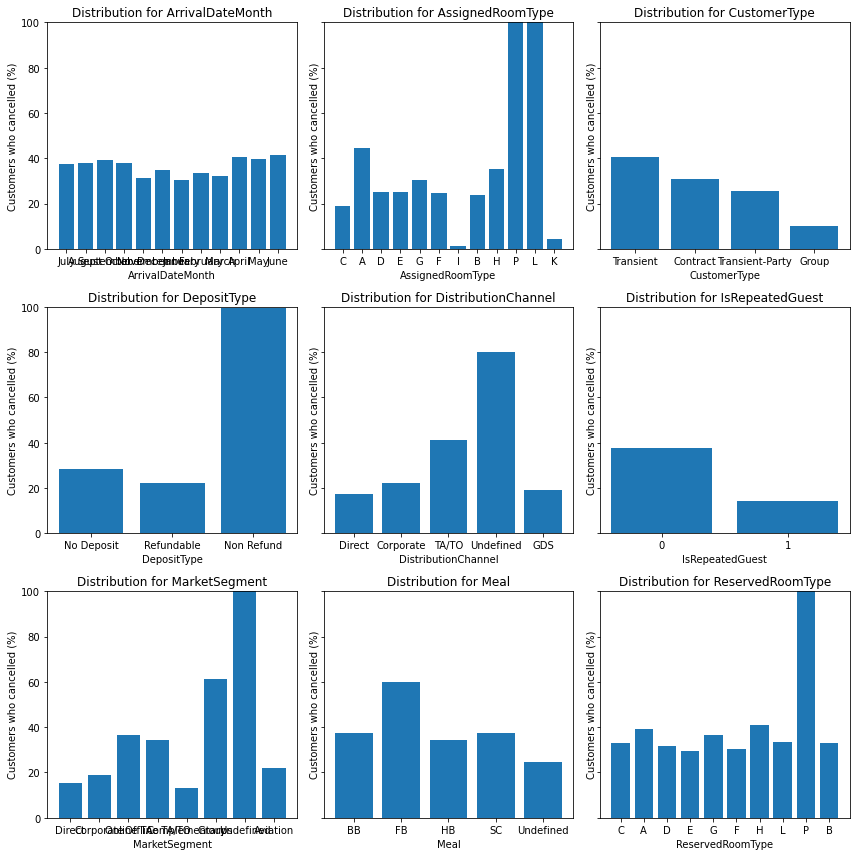

In [72]:
rem = ['IsCancelled','hotel','Agent','Company','Country']
cat = [col for col in categoricals if col not in rem]

fig, axes = plt.subplots(3, 3, sharey=True, figsize=(12,12))
for i, col in enumerate(cat):   
    ax = axes.flat[i]
        
    cat_values = [val for val in d[col].unique() if str(val) != 'nan']
    
    Cancelled = [len(d[(d[col] == val) & (d.IsCancelled == 1)]) 
        / len(d[d[col] == val]) for val in cat_values]
    Cancelled = [x * 100 for x in Cancelled]
        
    ax.bar([str(x) for x in cat_values], Cancelled)
    ax.set_ylim(0, 100)
    ax.set_xlabel(f"{col}")
    ax.set_ylabel('Customers who cancelled (%)')
    ax.set_title(f"Distribution for {col}")

fig.tight_layout();

### Room Type

In the first place, guests with reservations for room categories P and L, cancel their reservations more frequently. The high cancellation percentage in these rooms should be a matter to review by the hotel. This information leads us to conclude that guests' preference for the assigned room type, regardless of the month, may be a factor in cancellation.

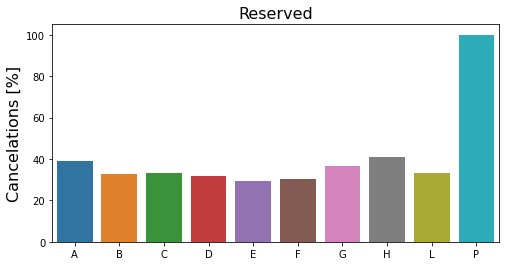

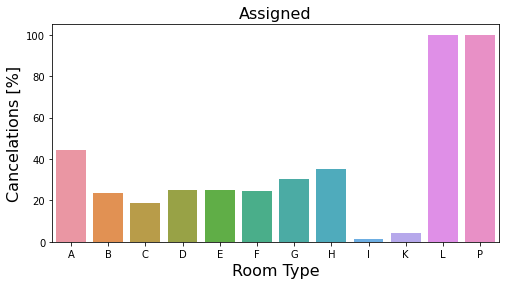

In [89]:
room_type = d.groupby("ReservedRoomType")["IsCancelled"].describe()
as_room_type = d.groupby("AssignedRoomType")["IsCancelled"].describe()

#show figure:
plt.figure(figsize=(8, 4))
sns.barplot(x=room_type.index, y=room_type["mean"] * 100)
plt.title("Reserved", fontsize=16)
plt.xlabel("", fontsize=1)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()
plt.figure(figsize=(8, 4))
plt.title("Assigned", fontsize=16)
sns.barplot(x=as_room_type.index, y=as_room_type["mean"] * 100)
plt.xlabel("Room Type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

### Deposit Type

Another variable highly correlated with cancellation was the deposit type. Seemingly counter-intuitively cancellations were highest when no refund was offered. While initially this might seem strange, it could be driven by something the hotel are doing. For example, perhaps the hotel are not offering refunds in circumstances where clients are more likely to cancel, this resulting in this counter-intuitive graph.

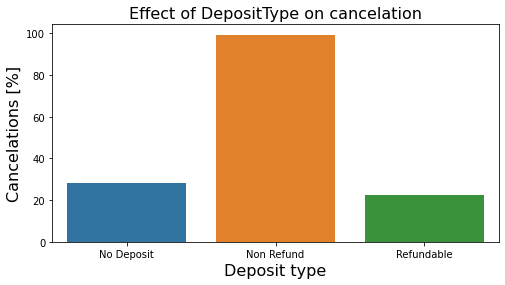

In [74]:
deposit_cancel_data = d.groupby("DepositType")["IsCancelled"].describe()

#show figure:
plt.figure(figsize=(8, 4))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of DepositType on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

### Price and Occupation per Month

The room price per night, as depicted in the graph below. From this we better understand the differences between the two hotel types. The Resort hotel unsurprisingly has peaks in the holidays, particularly in the summer. In fact, this is the only time through the year the price is higher than the City hotel. The City hotel price actually dips in the holidays, presumably because people are more inclined to leave the city at this time. The findings here reinforce the need to view these hotels separately.

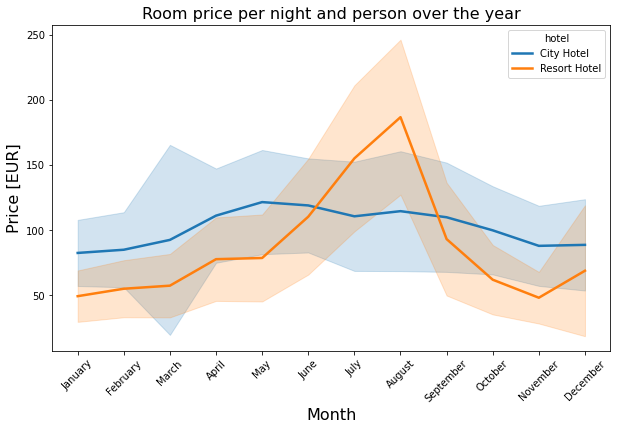

In [71]:
# grab data:
room_prices_mothly = d[["hotel", "ArrivalDateMonth", "ADR"]].sort_values("ArrivalDateMonth")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["ArrivalDateMonth"] = pd.Categorical(room_prices_mothly["ArrivalDateMonth"], categories=ordered_months, ordered=True)
blues = 'b', 'dodgerblue'

# barplot with standard deviation:
plt.figure(figsize=(10, 6))
sns.lineplot(x = "ArrivalDateMonth", y="ADR", hue="hotel", data=room_prices_mothly,
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

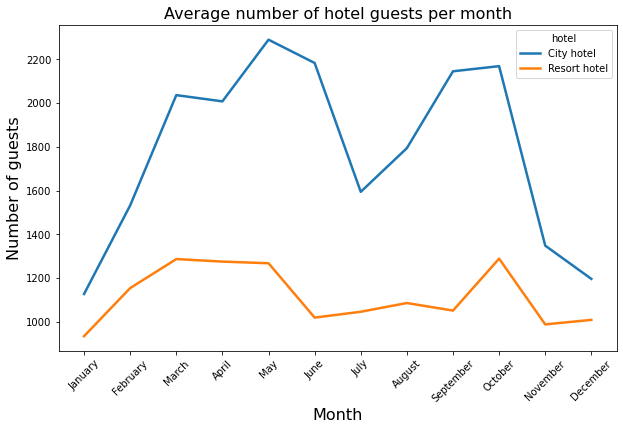

In [39]:
# Create a DateFrame with the relevant data:
rh = d.loc[(d["hotel"] == "Resort Hotel") & (d["IsCancelled"] == 0)]
ch = d.loc[(d["hotel"] == "City Hotel") & (d["IsCancelled"] == 0)]

resort_guests_monthly = rh.groupby("ArrivalDateMonth")["hotel"].count()
city_guests_monthly = ch.groupby("ArrivalDateMonth")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(10, 6))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

## ML Model - Predict Cancellations

The objective of this model is to try to predict whether a customer will cancel a reservation based on what the customer has learned from the training dataset. Three models will be evaluated to choose the one with the best accuracy.

### Set up the data
Prepare the data to run the model and divide the dataset by hotel type

### Divide the dataset by the hotel type

As can be seen in the graph, the City Hotel has a higher number of cancellations in reservations than the Resort Hotel, with 42% and 28% respectively. It is possible that this is due to the planning of the trip on the part of the clients, given that the Resort hotels may be more related to leisure, while the city hotels with work where there may be more changes or unforeseen events.

Total bookings cancelled: 44,224 (37%)
H1 ~ Resort hotel bookings cancelled: 11,122 (28%)
H2 ~ City hotel bookings cancelled: 33,102 (42%)


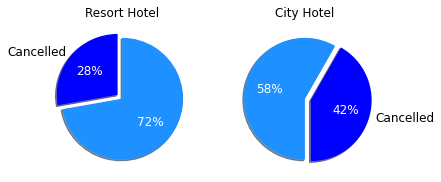

In [15]:
H1 = d[d['hotel'] == 'Resort Hotel']
H2 = d[d['hotel'] == 'City Hotel']

# Total cancelations:
T_cancel = d["IsCancelled"].sum()
H1_cancel = H1["IsCancelled"].sum()
H2_cancel = H2['IsCancelled'].sum()

# As percentage:
T_per = T_cancel / d.shape[0] * 100
H1_per = H1_cancel / H1.shape[0] * 100
H2_per = H2_cancel / H2.shape[0] * 100

print(f"Total bookings cancelled: {T_cancel:,} ({T_per:.0f}%)")
print(f"H1 ~ Resort hotel bookings cancelled: {H1_cancel:,} ({H1_per:.0f}%)")
print(f"H2 ~ City hotel bookings cancelled: {H2_cancel:,} ({H2_per:.0f}%)")

# Charts by hotel
labels = 'Cancelled', ''
H1_ax = [H1_per/100, (1-H1_per/100)]
H2_ax = [H2_per/100, (1-H2_per/100)]
blues = 'b', 'dodgerblue'
explode = (0.1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)

# H1
_, _, autotexts = ax1.pie(H1_ax, explode = explode, labels=labels, startangle=90, 
    colors = blues, autopct='%.0f%%', shadow=True, textprops={'size': 'large'})
for autotext in autotexts:
    autotext.set_color('white')
ax1.set_title("Resort Hotel")

# H2
_, _, autotexts = ax2.pie(H2_ax, explode = explode, colors = blues, startangle=270,
    labels=labels, autopct='%.0f%%', shadow=True, textprops={'size': 'large'})
for autotext in autotexts:
    autotext.set_color('white', )
ax2.set_title("City Hotel")

plt.show()


### Correlations

In [42]:
print("Less Influencials")
abs(d.corr().IsCancelled).sort_values().head()

Less Influencials


StaysInWeekendNights     0.001791
Children                 0.005036
ArrivalDateDayOfMonth    0.006130
ArrivalDateWeekNumber    0.008148
ArrivalDateYear          0.016660
Name: IsCancelled, dtype: float64

When analyzing the correlation of the variables with the cancellation of the reservations, we took out the ones with the least influence (<0.02)

In [26]:
remove = ['ArrivalDateWeekNumber','ArrivalDateDayOfMonth',
    'StaysInWeekendNights', 'Children', 'ArrivalDateYear']

categoricals = [col for col in categoricals if col not in remove]
numericals = [col for col in numericals if col not in remove]
d = d.drop(labels = remove, axis=1)

In [48]:
print("More Influencials")
abs(d.corr().IsCancelled).sort_values(ascending = False).head()

More Influencials


IsCancelled                 1.000000
LeadTime                    0.293123
TotalOfSpecialRequests      0.234658
RequiredCarParkingSpaces    0.195498
BookingChanges              0.144381
Name: IsCancelled, dtype: float64

On the other hand, the variables with higher influence over the canceleld booking can be observerd in the table above. So let's analyse, the correlation with the Lead time:

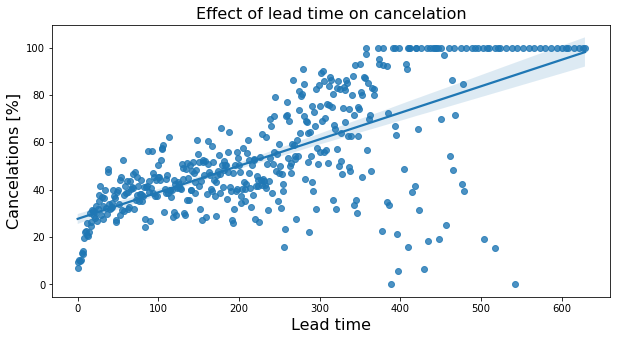

In [66]:
# group data for lead_time:
lead_cancel_data = d.groupby("LeadTime")["IsCancelled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(10, 5))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

The lead time had one of the highest correlations with cancellations. Unsurprisingly , bookings made at extremely short notice were unlikely to be cancelled. Bookings with a longer lead time had a wide dispersion of cancellations. However, the trend line clearly shows a positive correlation with cancellations and lead time, helping us to understand lead time is likely to be a driving factor behind why customers may cancel. It may also be of the hotels interest to consider how much of an operational issue this is. If the lead time is long, but the client gives a lot of notice when cancelling, this room could be resold, having limited effect on the operations of the business.

### **ML Model**

**1. Training the model**

- Separate the data into a training set 90% and a test set 10%.  
- The Kfold will by splitted into 5 (80 - 20).  
  
For better precision of the model, we set it to shuffle the data before splitting it into batches. Lastly, we choose the ordering of the indices to start from 0, as it is typical for machine learning and as it would be convenient for us to work with later.


In [27]:
# H1 - Resort Hotel
X1 = H1.drop(label, axis=1)
y1 = H1[label]

# H2 - City Hotel
X2 = H2.drop(label, axis=1)
y2 = H2[label]


# Set the training and test sample. In this case 90-10
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1 , 
    test_size=0.1, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2 , 
    test_size=0.1, stratify=y2)

#K-Fold = 80-20
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

**2. Set the preprocessor**  
  
We begin by creating a pipeline that transforms the data into a more practical format and imputes data wherever there is missing data using the MinMaxScaler tool for the numerical variables and the OneHotEncoder for the categorical variables. Then we set a Simple Imputer to then replace missing values with fill_value (strategy = constant). Given that, by focusing on a mean gives you an average score of the total number, an estimation can be properly made, and for the most frequent to look for a more accurate value of the cancellations made. To finish the model the SVC kernel must be implemented to properly run the code.

In [28]:
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='constant'),
    MinMaxScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numericals),
    ('categorical', categorical_transformer, categoricals)
])

**3. Compare and select the model**  
  
Below, 3 Binary Classification models will be evaluated to determine the one with the best accuracy and best fit for this case study. Only the H1 data set (Resort Hotel), will be used to test the different models, since it's not necessary to use the entire dataset (~120.000 rows).

#### Model Selection
We compare different models...

##### Model A: Linear Support Vector Classifier  

This model identifies the support vectors, which are the closest data points to the line classifying whether the customer canceled or not (the hyperplane). Then, the distance between the support vectors and the hyperplane is maximized to find the optimal hyper-plane. Using this method, we receive the following results. 

In [29]:
model_ls = make_pipeline(
    preprocessor,
    SVC(kernel='linear', max_iter=10000, verbose=True)
)

[LibSVM]

c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Accuracy on test set: 85.22%
Recall on test set: 71.22%
F1 Score on test set: 81.33%


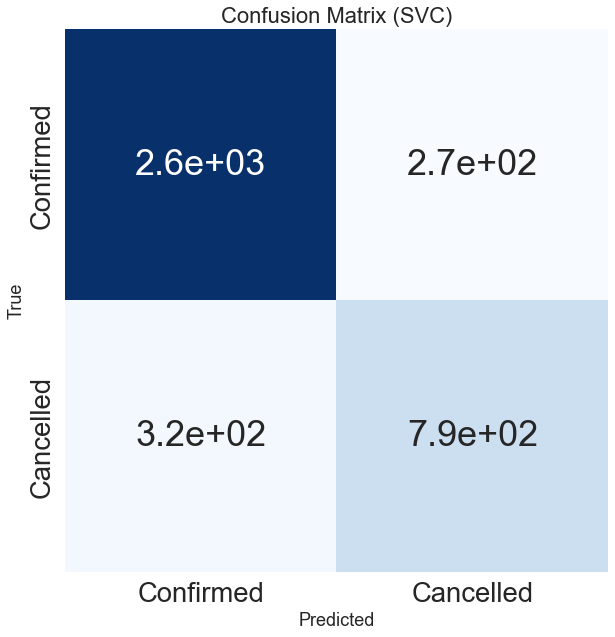

In [30]:
# Model Fit
model_ls.fit(X1_train, y1_train)
pred = model_ls.predict(X1_test)
print(f"Accuracy on test set: {accuracy_score(y1_test, pred)*100:.2f}%")
print(f"Recall on test set: {recall_score(y1_test, pred)*100:.2f}%")
print(f"F1 Score on test set: {f1_score(y1_test, pred, average='macro')*100:.2f}%")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=3.0)
sns.heatmap(confusion_matrix(y1_test, pred), 
    square=True, annot=True, cmap='Blues', cbar=False, ax=ax);
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('True', fontsize=18)
ax.set_title('Confusion Matrix (SVC)', fontsize=22)
ax.set_xticklabels(['Confirmed', 'Cancelled'])
ax.set_yticklabels(['Confirmed', 'Cancelled']);

##### Model B: RBF Support Vector Machine

The difference between the approaches is how they determine the hyperplanes. RBF is usually the most comprehensive, normally requiring the highest computational power and usually providing the highest accuracy/recall scores. The downside is that the higher the accuracy on the training set usually leads to less ability to generalize to the rest of the test set. The RBF function gives the following results.

In [31]:
model_rbf = make_pipeline(
    preprocessor,
    SVC(kernel='rbf', max_iter=10000)
)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Accuracy on test set: 86.84%
Recall on test set: 69.60%
F1 Score on test set: 82.86%


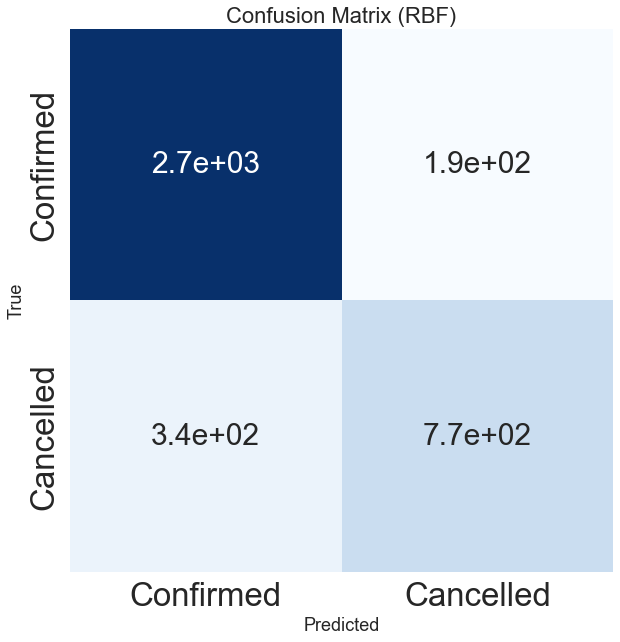

In [33]:
# H1
model_rbf.fit(X1_train, y1_train);
pred_rbf = model_rbf.predict(X1_test)
print(f"Accuracy on test set: {accuracy_score(y1_test, pred_rbf)*100:.2f}%")
print(f"Recall on test set: {recall_score(y1_test, pred_rbf)*100:.2f}%")
print(f"F1 Score on test set: {f1_score(y1_test, pred_rbf, average='macro')*100:.2f}%")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=2.5)
sns.heatmap(confusion_matrix(y1_test, pred_rbf), 
    square=True, annot=True, cmap='Blues', cbar=False, ax=ax);
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('True', fontsize=18)
ax.set_title('Confusion Matrix (RBF)', fontsize=22)
ax.set_xticklabels(['Confirmed', 'Cancelled'])
ax.set_yticklabels(['Confirmed', 'Cancelled']);

##### Model C: Polynomial support vector machine

The Polynomial Support Vector machine is used when data is non-linear, by adding another dimension. This allows for a linear support vector classifier to be implemented. The Polynomial function gives the following results. 

In [14]:
model_poly = make_pipeline(
    preprocessor,
    SVC(kernel='poly', max_iter=20000)
)
model_poly2 = make_pipeline(
    preprocessor,
    SVC(kernel='poly', max_iter=10000)
)

Resort Hotel
Accuracy on test set: 87.12%
Recall on test set: 70.77%
F1 Score on test set: 83.30%



c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


City Hotel
Accuracy on test set: 84.97%
Recall on test set: 79.03%
F1 Score on test set: 84.41%


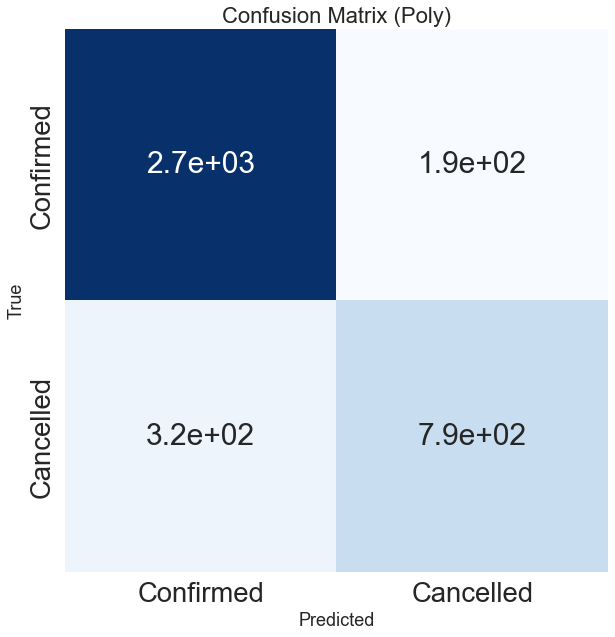

In [37]:
# H1
model_poly.fit(X1_train, y1_train);
pred_poly = model_poly.predict(X1_test)
print('\033[1m' + "Resort Hotel" + '\033[0m')
print(f"Accuracy on test set: {accuracy_score(y1_test, pred_poly)*100:.2f}%")
print(f"Recall on test set: {recall_score(y1_test, pred_poly)*100:.2f}%")
print(f"F1 Score on test set: {f1_score(y1_test, pred_poly, average='macro')*100:.2f}%")
print('')

# H2
model_poly2.fit(X2_train, y2_train);
pred_poly2 = model_poly2.predict(X2_test)
print('\033[1m' + "City Hotel" + '\033[0m')
print(f"Accuracy on test set: {accuracy_score(y2_test, pred_poly2)*100:.2f}%")
print(f"Recall on test set: {recall_score(y2_test, pred_poly2)*100:.2f}%")
print(f"F1 Score on test set: {f1_score(y2_test, pred_poly2, average='macro')*100:.2f}%")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=2.5)
sns.heatmap(confusion_matrix(y1_test, pred_poly), 
    square=True, annot=True, cmap='Blues', cbar=False, ax=ax);
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('True', fontsize=18)
ax.set_title('Confusion Matrix (Poly)', fontsize=22)
ax.set_xticklabels(['Confirmed', 'Cancelled'])
ax.set_yticklabels(['Confirmed', 'Cancelled']);

## Conclusion


In [38]:
print('\033[1m' + "Accuracy on test set: " + '\033[0m')
print(f"LS: {accuracy_score(y1_test, pred)*100:.2f}%   -   "+
    f"RBF: {accuracy_score(y1_test, pred_rbf)*100:.2f}%   -   "+
    f"Poly: {accuracy_score(y1_test, pred_poly)*100:.2f}%")

print('\033[1m' + "Recall on test set: " + '\033[0m')
print(f"LS: {recall_score(y1_test, pred)*100:.2f}%   -   "+
    f"RBF: {recall_score(y1_test, pred_rbf)*100:.2f}%   -   "+
    f"Poly: {recall_score(y1_test, pred_poly)*100:.2f}%")

print('\033[1m' + "F1 Score on test set: " + '\033[0m') 
print(f"LS: {f1_score(y1_test, pred, average='macro')*100:.2f}%   -   "+
    f"RBF: {f1_score(y1_test, pred_rbf, average='macro')*100:.2f}%   -   "+
    f"Poly: {f1_score(y1_test, pred_poly, average='macro')*100:.2f}%")



Accuracy on test set: 
LS: 85.22%   -   RBF: 86.84%   -   Poly: 87.12%
Recall on test set: 
LS: 71.22%   -   RBF: 69.60%   -   Poly: 70.77%
F1 Score on test set: 
LS: 81.33%   -   RBF: 82.86%   -   Poly: 83.30%


The optimal model is split equally between the Polynomial and the RBF model, with very little between the accuracy, recall and F1 scores. There is a need to increase dimensions, demonstrated in the improved accuracy that the Polynomial and RBF model provide. Here we have successfully tackled the classification problem and this could be implemented into the hotel's operations. 